In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSTyupJYW8-dOI7rTKOVE-bMT4M_8UnVnRLOJGavyVh33-4wHTkP4Q-uWX9mwMQul2kxMl8aJLR0FHB/pub?output=csv")

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [3]:


named_data <- data %>%
    rename(
        monday = weekday_is_monday,
        tuesday = weekday_is_tuesday,
        wednesday = weekday_is_wednesday,
        thursday = weekday_is_thursday,
        friday = weekday_is_friday,
        saturday = weekday_is_saturday,
        sunday = weekday_is_sunday,
        lifestyle = data_channel_is_lifestyle,
        entertainment =  data_channel_is_entertainment,
        business = data_channel_is_bus,
        social_media =  data_channel_is_socmed,
        technology =  data_channel_is_tech,
        world =  data_channel_is_world
    )


Genre,Day_Of_Week,shares,abs_pos_neg_ratio
<fct>,<fct>,<dbl>,<dbl>
entertainment,monday,593,3.606061
business,monday,711,6.644338
business,monday,1500,6.375000
entertainment,monday,1200,2.088008
technology,monday,505,11.490024
technology,monday,855,1.977800


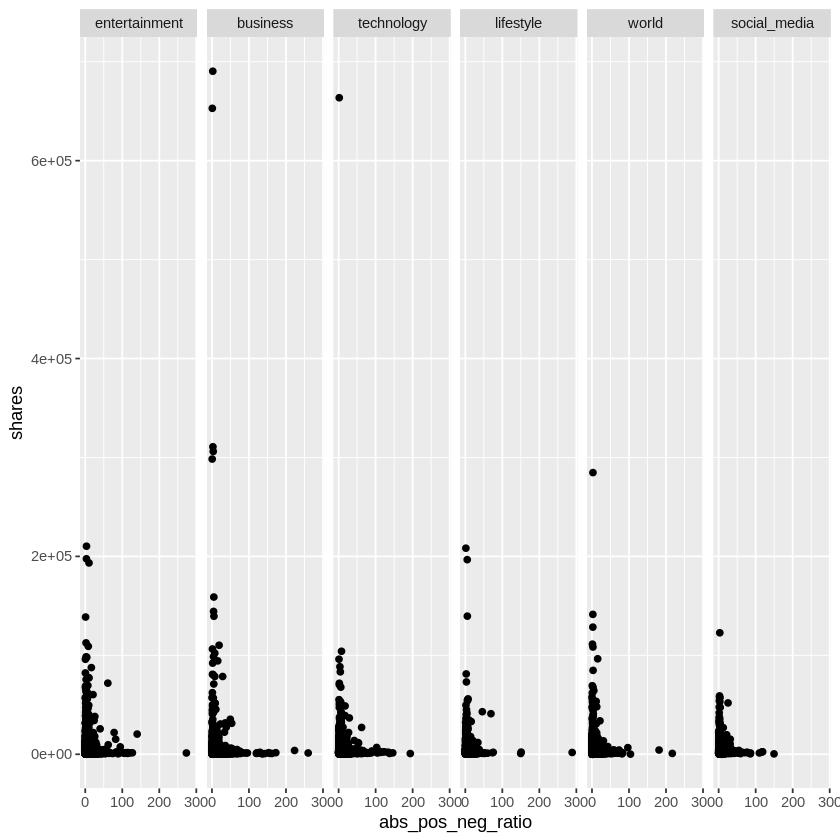

In [4]:
#It didn't work when all in one pipe, I have no idea why. This seems to work though
tidy_data <- named_data %>%
    pivot_longer(cols =  lifestyle:world, 
                 names_to = 'Genre', 
                 values_to = 'Genre_Present') %>%
    filter(Genre_Present == 1) %>%
    pivot_longer(cols =   monday:sunday, 
                 names_to = 'Day_Of_Week', 
                 values_to = 'Day_Present') %>%
    filter(Day_Present == 1) %>%
    mutate(abs_pos_neg_ratio = (global_rate_positive_words*avg_positive_polarity)/abs(global_rate_negative_words*avg_negative_polarity)) %>%
    filter(global_rate_positive_words != 0 & global_rate_negative_words != 0) %>%
    mutate(Genre = as_factor(Genre)) %>%
    mutate(Day_Of_Week = as_factor(Day_Of_Week)) %>%
    select(Genre, Day_Of_Week, shares,  abs_pos_neg_ratio)

head(tidy_data)

share_plot <- ggplot(tidy_data, aes(x = abs_pos_neg_ratio, y = shares))+
            geom_point()+
  facet_grid( ~ Genre)


share_plot

In [7]:
set.seed(1234)
publishing_split <- initial_split(tidy_data, prop = 0.75, strata = shares)
publishing_train <- training(publishing_split)
publishing_test <- testing(publishing_split)

head(publishing_train)

day_table <- publishing_train %>%
    group_by(Day_Of_Week) %>%
    summarize(total_articles=n(), avg_shares=mean(shares),abs_pos_neg_ratio = mean(abs_pos_neg_ratio))
day_table
#grouped by the day of the week so we can summarize the total amount of articles of that day of the week, the average shares of that day of the week, and the positive to negative word ratio of that day of the week

genre_table <- publishing_train %>%
    group_by(Genre) %>%
    summarize(total_articles=n(), avg_shares=mean(shares),abs_pos_neg_ratio = mean(abs_pos_neg_ratio) )
genre_table
#grouped by the genre so we can summarize the total articles from that genre, the average shares of that genre and the positive to negative word ratio of that genre

Genre,Day_Of_Week,shares,abs_pos_neg_ratio
<fct>,<fct>,<dbl>,<dbl>
entertainment,monday,593,3.606061
business,monday,711,6.644338
business,monday,1500,6.375000
entertainment,monday,1200,2.088008
technology,monday,505,11.490024
technology,monday,855,1.977800


`summarise()` ungrouping output (override with `.groups` argument)



Day_Of_Week,total_articles,avg_shares,abs_pos_neg_ratio
<fct>,<int>,<dbl>,<dbl>
monday,4127,3291.147,5.557789
tuesday,4450,2912.012,5.569685
wednesday,4541,2736.875,5.786478
thursday,4399,2615.882,5.714597
friday,3336,2743.868,5.507377
saturday,1467,3410.397,6.016696
sunday,1566,3438.182,5.732662


`summarise()` ungrouping output (override with `.groups` argument)



Genre,total_articles,avg_shares,abs_pos_neg_ratio
<fct>,<int>,<dbl>,<dbl>
entertainment,5045,2861.388,4.749150
business,4439,3110.126,6.955632
technology,5258,3088.678,7.150733
lifestyle,1502,3725.748,6.094560
world,5975,2321.019,3.808800
social_media,1667,3642.015,6.579349


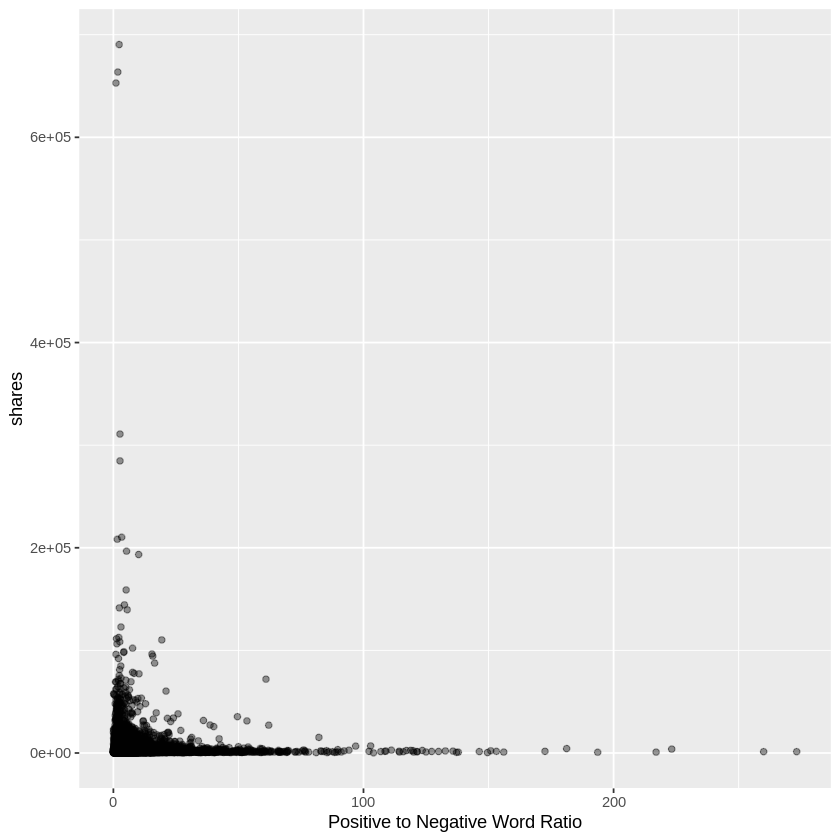

In [8]:
share_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("regression") 



share_recipe <- recipe(shares ~ ., data = publishing_train) %>%
       step_scale(-shares, -Day_Of_Week, -Genre) %>%
       step_center(-shares, -Day_Of_Week, -Genre)

share_plot <- ggplot(publishing_train, aes(x = abs_pos_neg_ratio, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Positive to Negative Word Ratio")

#head(publishing_train)
share_plot

In [9]:
shares_vfold <- vfold_cv(publishing_train, v = 5, strata = shares)


share_workflow <- workflow() %>%
       add_recipe(share_recipe) %>%
       add_model(share_spec)

gridvals <- tibble(neighbors = 1:250) %>%
    filter(neighbors %% 10 == 0 )

share_results <- share_workflow %>%
    tune_grid(resamples = shares_vfold, grid = gridvals) %>%
    collect_metrics()

share_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,rmse,standard,1.012991e+04,5,1.346428e+03,Model01
10,rsq,standard,8.541566e-04,5,4.361371e-04,Model01
20,rmse,standard,9.927921e+03,5,1.412684e+03,Model02
20,rsq,standard,7.509730e-04,5,3.610432e-04,Model02
30,rmse,standard,9.830013e+03,5,1.428614e+03,Model03
30,rsq,standard,1.510202e-03,5,7.485592e-04,Model03
40,rmse,standard,9.764219e+03,5,1.443707e+03,Model04
40,rsq,standard,2.230065e-03,5,9.309215e-04,Model04
50,rmse,standard,9.733758e+03,5,1.450777e+03,Model05


In [10]:
share_min <- share_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>% 
    slice(1)

share_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
250,rmse,standard,9663.202,5,1463.143,Model25


In [11]:
k_min <- share_min %>%
          pull(neighbors)

share_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
          set_engine("kknn") %>%
          set_mode("regression")

share_best_fit <- workflow() %>%
          add_recipe(share_recipe) %>%
          add_model(share_best_spec) %>%
          fit(data = publishing_train)

share_summary <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test) %>%
           metrics(truth = shares, estimate = .pred)
share_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,8.010566e+03
rsq,standard,7.287569e-04
mae,standard,2.534805e+03


In [12]:
share_preds <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test)

options(repr.plot.width = 15, repr.plot.height = 15)

share_plot <- ggplot(share_preds, aes(x = abs_pos_neg_ratio, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Positive to Negative Word Ratio")+
  geom_line(data = share_preds, aes(x = abs_pos_neg_ratio, y = .pred), color = "blue")+
  facet_grid(Genre ~ Day_Of_Week)+
  geom_smooth(method = "lm", se = FALSE, data=publishing_train)+
  ggtitle("Shares by Pos Neg Ratio")

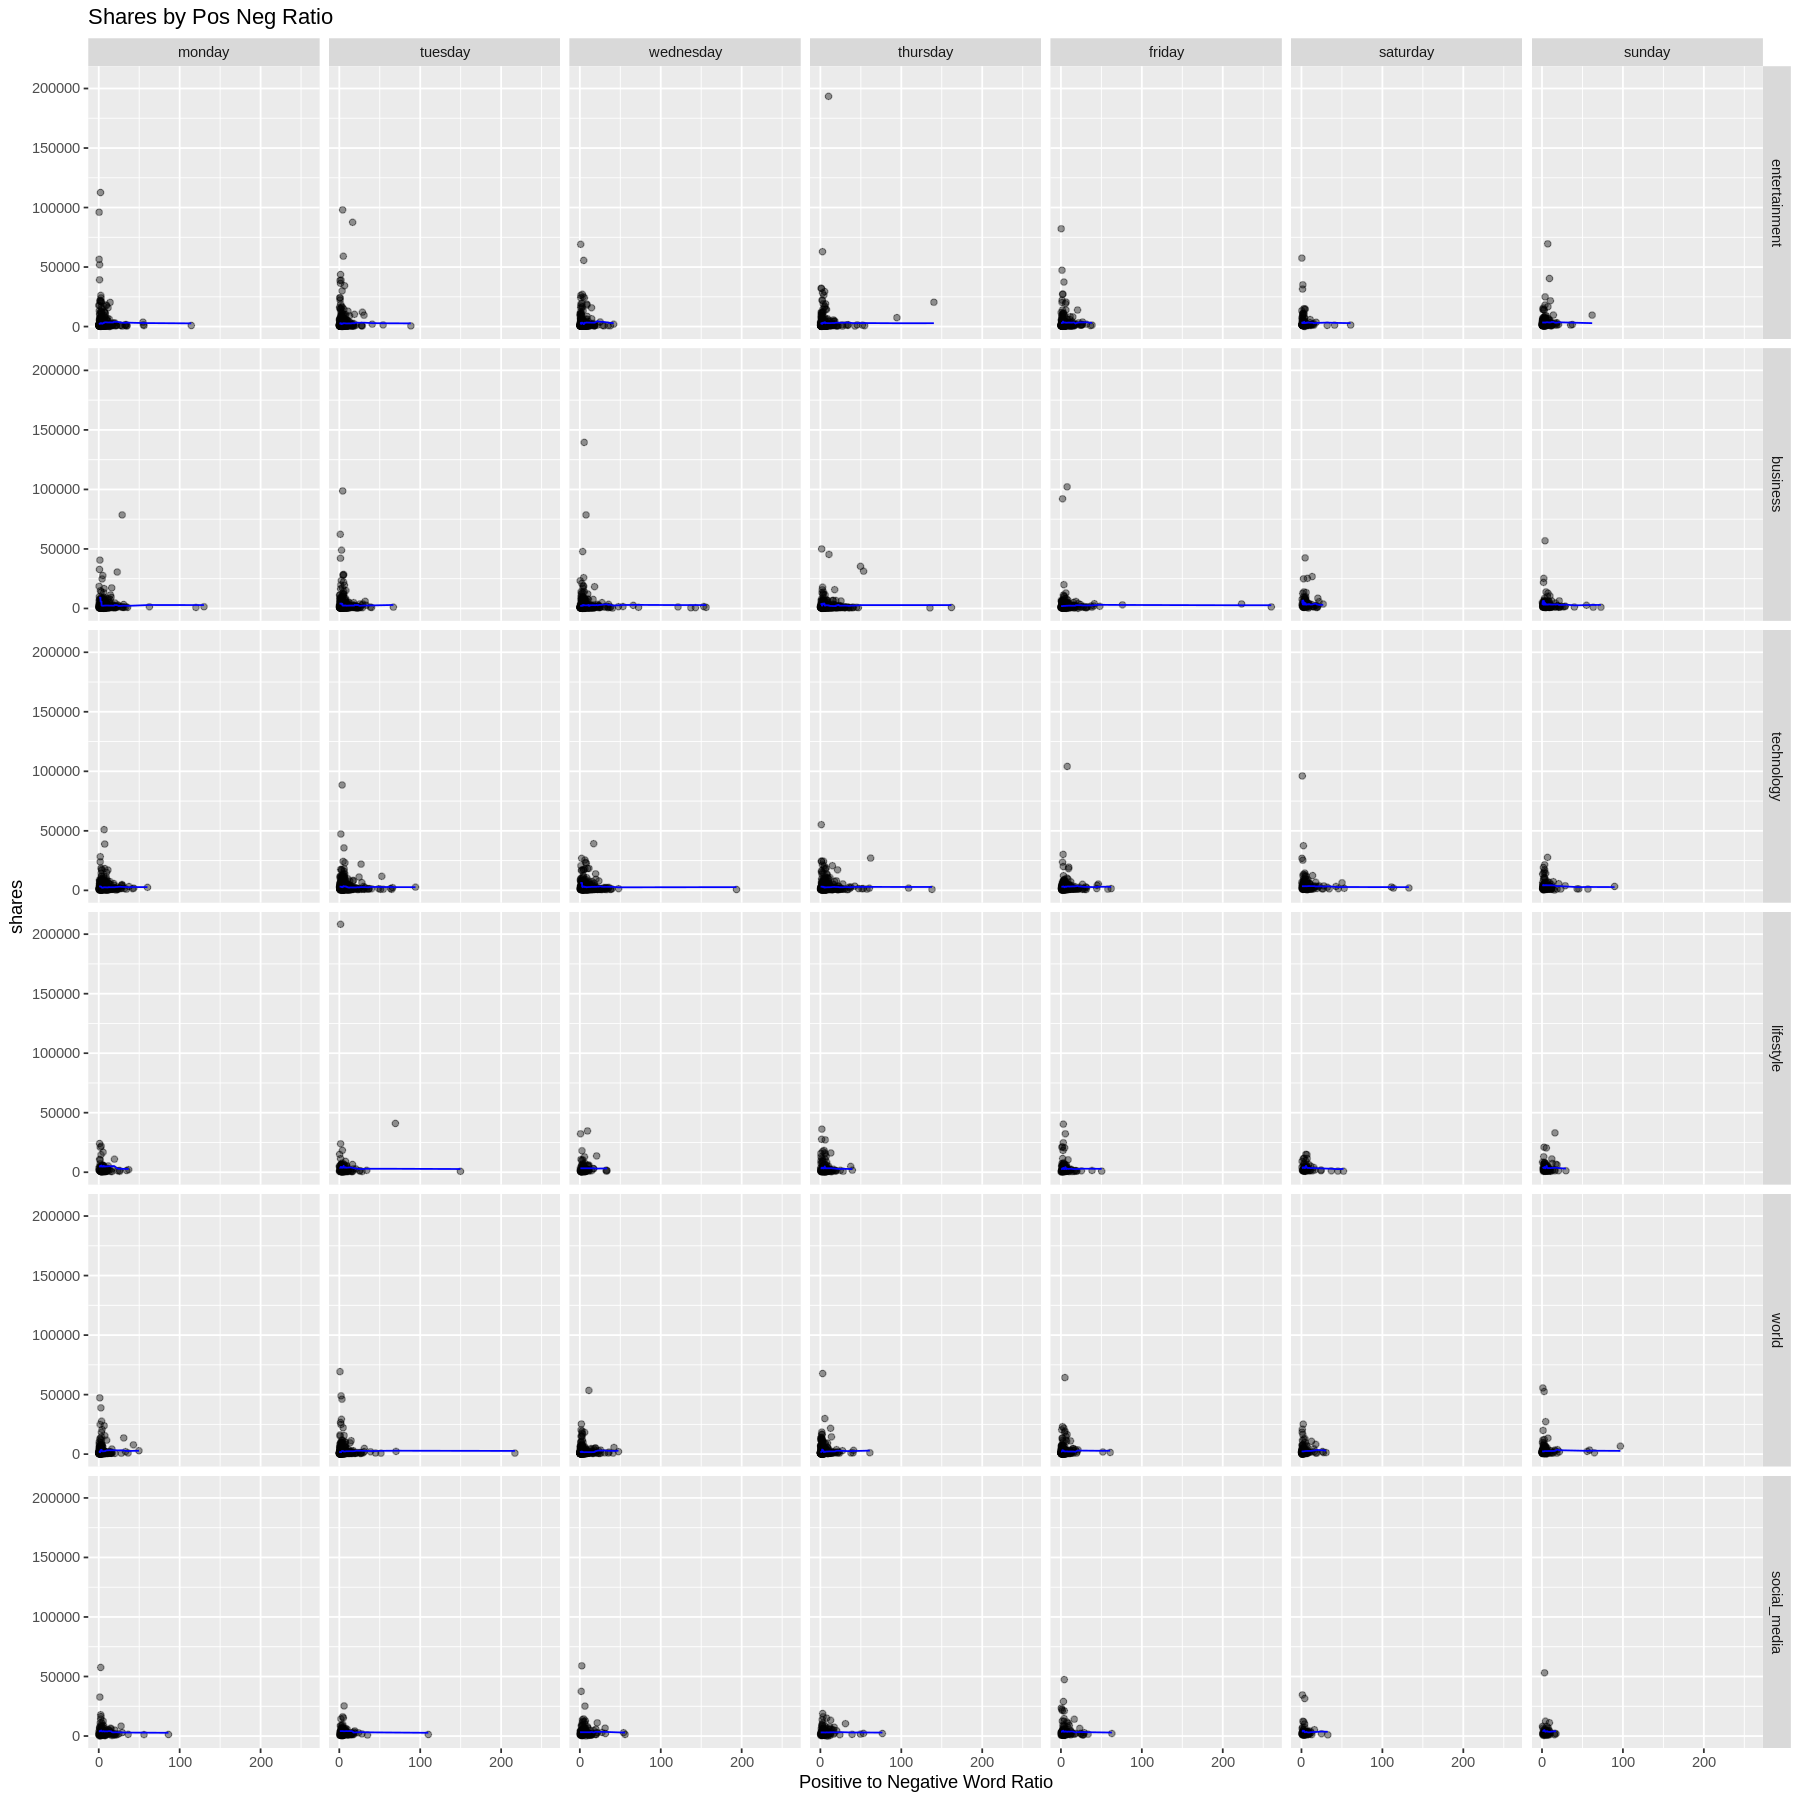

In [23]:
share_plot